[*********************100%***********************]  1 of 1 completed



Raw data info:
Data shape: (2298, 6)
Data columns: MultiIndex([('Datetime',   ''),
            (   'Close', 'PG'),
            (    'High', 'PG'),
            (     'Low', 'PG'),
            (    'Open', 'PG'),
            (  'Volume', 'PG')],
           names=['Price', 'Ticker'])
Data index: <class 'pandas.core.indexes.range.RangeIndex'>

First few rows of raw data:
Price                   Datetime       Close        High         Low  \
Ticker                                    PG          PG          PG   
0      2024-01-02 14:30:00+00:00  148.729996  148.929993  146.309998   
1      2024-01-02 15:30:00+00:00  148.348206  149.410004  148.240005   
2      2024-01-02 16:30:00+00:00  148.350006  148.690002  148.279999   
3      2024-01-02 17:30:00+00:00  148.449997  148.679993  148.210007   
4      2024-01-02 18:30:00+00:00  148.770004  148.910004  148.324997   

Price         Open   Volume  
Ticker          PG       PG  
0       146.360001  1577064  
1       148.779999   808052  
2   

02:23:13 - cmdstanpy - INFO - Chain [1] start processing
02:23:17 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Jeremy\anaconda3\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(



Prophet model fitted successfully.


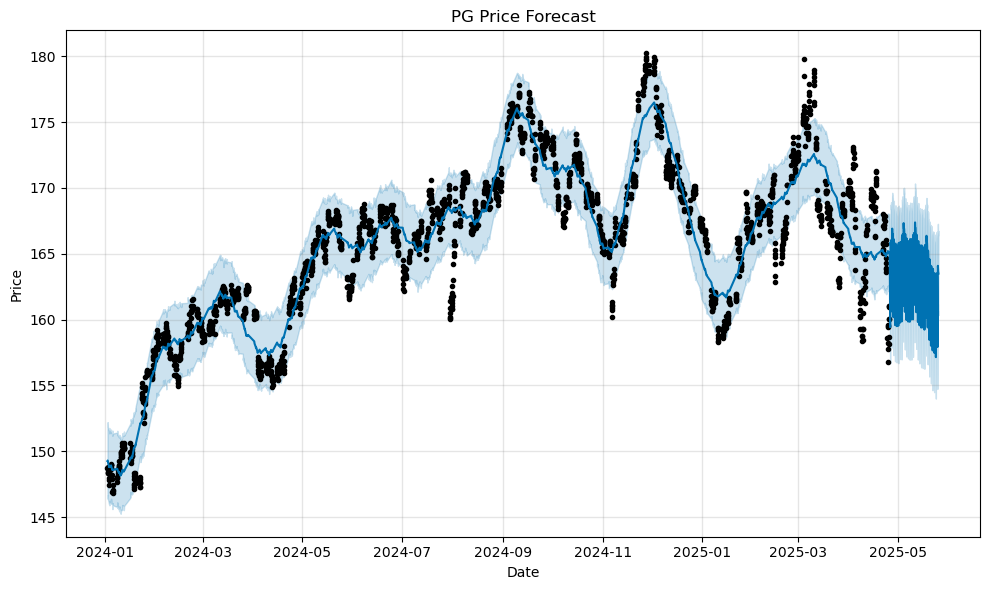

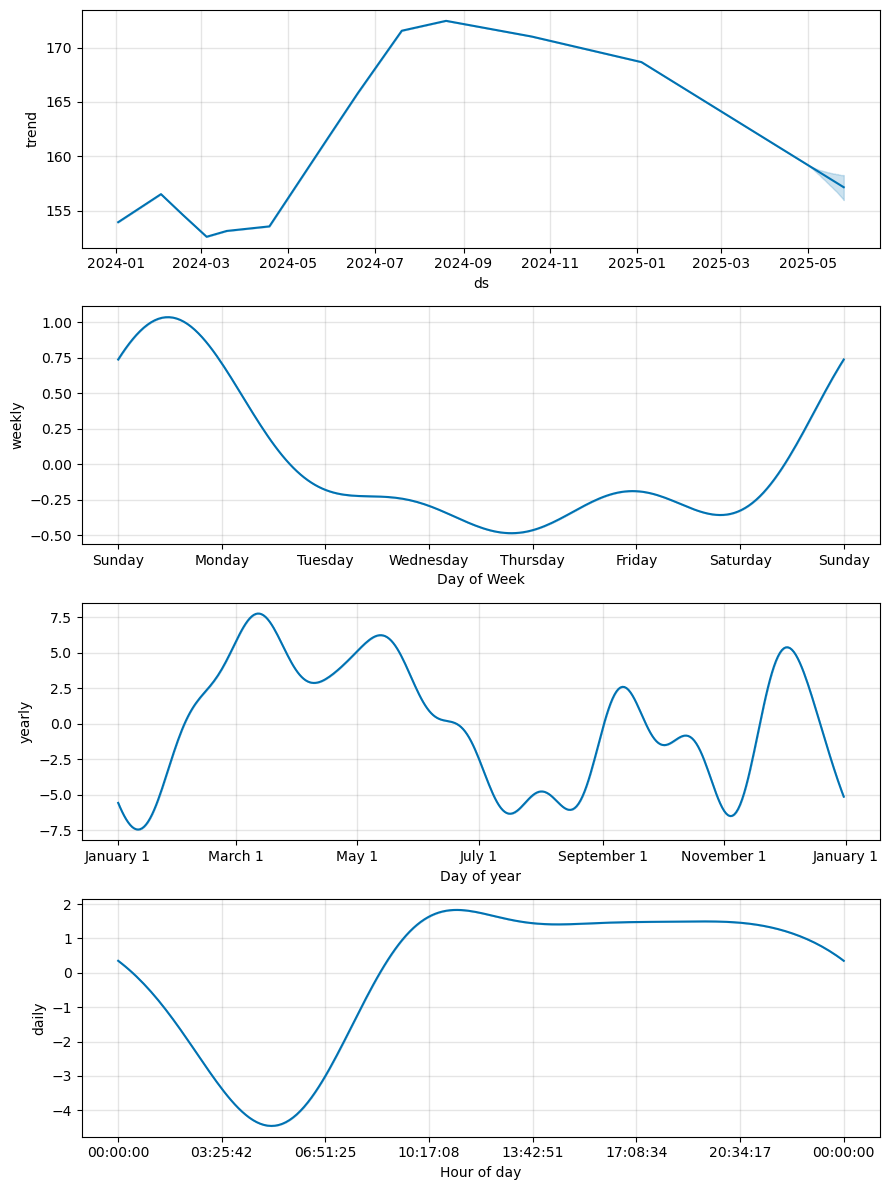


Latest Trading Signals:
                      ds           y        yhat  yhat_lower  yhat_upper  \
2274 2025-04-22 17:30:00  167.169998  165.050897  162.333182  167.725655   
2275 2025-04-22 18:30:00  167.470001  165.056485  162.213232  167.708283   
2276 2025-04-22 19:30:00  167.839996  165.057371  162.196473  167.662027   
2277 2025-04-23 13:30:00  166.029999  164.855897  162.186275  167.622467   
2278 2025-04-23 14:30:00  164.270004  164.793531  162.010974  167.375251   
2279 2025-04-23 15:30:00  163.589996  164.813290  161.960824  167.326038   
2280 2025-04-23 16:30:00  163.925003  164.843499  162.145188  167.397040   
2281 2025-04-23 17:30:00  163.875000  164.856811  162.393920  167.717545   
2282 2025-04-23 18:30:00  164.649902  164.866003  161.928565  167.456872   
2283 2025-04-23 19:30:00  165.720001  164.873219  162.375674  167.557773   
2284 2025-04-24 13:30:00  158.580002  165.098712  162.263857  167.826814   
2285 2025-04-24 14:30:00  156.804993  165.058786  162.550395  1

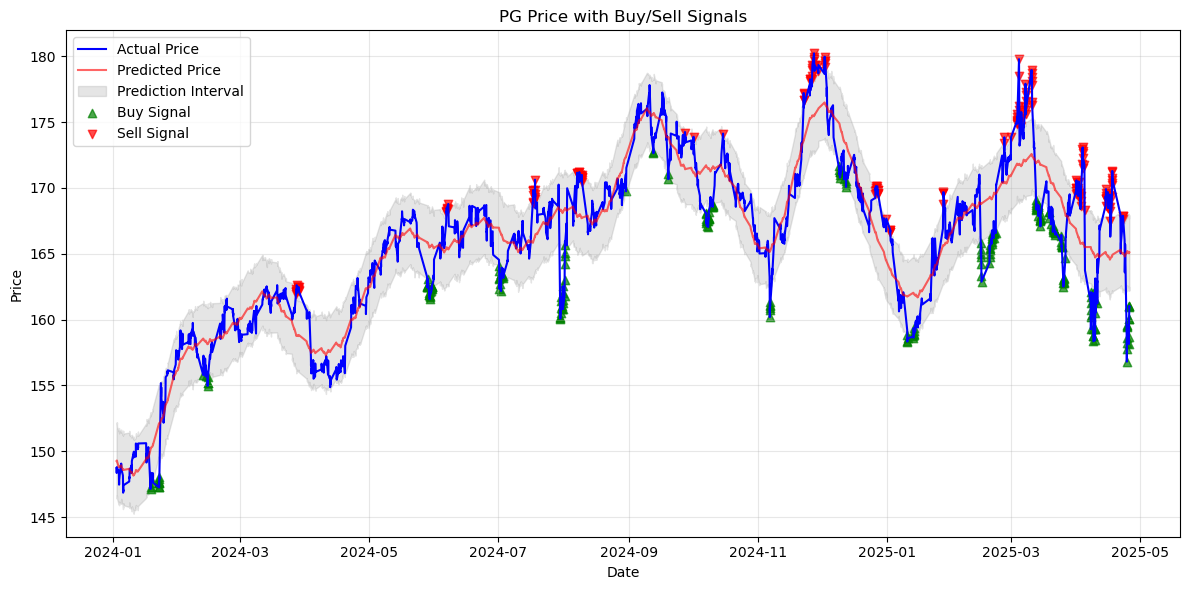

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt

# Step 1: Download hourly stock data using a valid date range
ticker = "PLTR"
# Using a date range from the past until present
data = yf.download(ticker, start="2024-01-01", end="2025-04-26", interval="1h")
data.reset_index(inplace=True)

# Print the raw data info for debugging
print("\nRaw data info:")
print(f"Data shape: {data.shape}")
print(f"Data columns: {data.columns}")
print(f"Data index: {type(data.index)}")
print("\nFirst few rows of raw data:")
print(data.head())

# Step 2: Flatten the MultiIndex if it exists
if isinstance(data.columns, pd.MultiIndex):
    print("\nDetected MultiIndex columns, flattening...")
    # Flatten MultiIndex columns
    data.columns = [f"{col[0]}_{col[1]}" if col[1] else col[0] for col in data.columns]
    print(f"New flattened columns: {data.columns}")

# Ensure we have the right date column
datetime_col = next((col for col in data.columns if col.startswith('Date') or col.startswith('Datetime')), None)
if datetime_col is None:
    print("\nERROR: Cannot find date column")
    print("Available columns:", data.columns)
    # Exit if no date column is found
    raise ValueError("Date column not found")

# Ensure we have the right price column (typically 'Close')
price_col = next((col for col in data.columns if col.startswith('Close')), None)
if price_col is None:
    print("\nERROR: Cannot find Close price column")
    print("Available columns:", data.columns)
    # Exit if no price column is found
    raise ValueError("Close price column not found")

# Now create a clean DataFrame with only the needed columns
processed_data = pd.DataFrame()

# CRITICAL FIX: Convert datetime to timezone-naive by removing the timezone info
processed_data['ds'] = pd.to_datetime(data[datetime_col]).dt.tz_localize(None)
processed_data['y'] = pd.to_numeric(data[price_col], errors='coerce')

# Check the processed data
print("\nProcessed data info:")
print(f"Processed data shape: {processed_data.shape}")
print(f"Processed data columns: {processed_data.columns}")
print("\nFirst few rows of processed data:")
print(processed_data.head())

# Check if timezone is properly removed
print("\nChecking if timezone is removed:")
print(f"Timezone info: {processed_data['ds'].dt.tz}")

# Drop any NaN values
processed_data = processed_data.dropna()

# Remove any infinite values
processed_data = processed_data[~processed_data['y'].isin([np.inf, -np.inf])]

# Double-check the column types
print("\nData Types after processing:")
print(processed_data.dtypes)

# Step 5: Fit the Prophet model
model = Prophet(daily_seasonality=True, yearly_seasonality=True)
try:
    model.fit(processed_data)
    print("\nProphet model fitted successfully.")
except Exception as e:
    print("\nError during Prophet model fitting:", e)
    # Print more debugging information
    print("\nDetailed data information before Prophet fitting:")
    print(f"Data shape: {processed_data.shape}")
    print(f"Data columns: {processed_data.columns}")
    print(f"Data types: {processed_data.dtypes}")
    print("\nFirst few rows of prepared data:")
    print(processed_data.head())
    print("\nChecking for any remaining issues:")
    print(f"Any NaN in 'ds': {processed_data['ds'].isnull().sum()}")
    print(f"Any NaN in 'y': {processed_data['y'].isnull().sum()}")
    # If error occurs, don't exit but raise the exception
    raise

# Step 6: Create future dataframe for forecast (30 days of hourly forecasts)
future = model.make_future_dataframe(periods=30 * 24, freq='H')
forecast = model.predict(future)

# Step 7: Plot forecast
fig1 = model.plot(forecast)
plt.title(f'{ticker} Price Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.tight_layout()
plt.show()

# Component plots for seasonality, trends
fig2 = model.plot_components(forecast)
plt.tight_layout()
plt.show()

# Step 8: Extract forecasted values
forecast_filtered = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

# Step 9: Merge with actuals
merged = pd.merge(processed_data, forecast_filtered, on='ds', how='left')

# Step 10: Generate Buy/Sell Signals
merged['Signal'] = np.where(merged['y'] < merged['yhat_lower'], 'Buy',
                           np.where(merged['y'] > merged['yhat_upper'], 'Sell', 'Hold'))

# Step 11: Display the latest signals
latest_signals = merged[['ds', 'y', 'yhat', 'yhat_lower', 'yhat_upper', 'Signal']].tail(24)
print("\nLatest Trading Signals:")
print(latest_signals)

# Step 12: Calculate signal statistics
signal_counts = merged['Signal'].value_counts()
print("\nSignal Distribution:")
print(signal_counts)

# Step 13: Plot the signals on historical data
plt.figure(figsize=(12, 6))
plt.plot(merged['ds'], merged['y'], label='Actual Price', color='blue')
plt.plot(merged['ds'], merged['yhat'], label='Predicted Price', color='red', alpha=0.6)
plt.fill_between(merged['ds'], merged['yhat_lower'], merged['yhat_upper'], 
                 color='gray', alpha=0.2, label='Prediction Interval')

# Plot buy and sell signals
buy_signals = merged[merged['Signal'] == 'Buy']
sell_signals = merged[merged['Signal'] == 'Sell']

plt.scatter(buy_signals['ds'], buy_signals['y'], color='green', label='Buy Signal', marker='^', alpha=0.7)
plt.scatter(sell_signals['ds'], sell_signals['y'], color='red', label='Sell Signal', marker='v', alpha=0.7)

plt.title(f'{ticker} Price with Buy/Sell Signals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()